<img src="https://i.postimg.cc/Zqg9M9F1/stacking-drawio.png"/>

In [1]:
import os
import pandas as pd
import numpy as np
import scipy
from pathlib import Path
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
!pip install mrmr_selection
from mrmr import mrmr_classif

from tqdm import tqdm
#ignore warning messages 
import warnings
warnings.filterwarnings('ignore') 
import random 
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold


from sklearn.metrics import log_loss

path = Path('/kaggle/input/tabular-playground-series-nov-2022/')

In [2]:
# SEED 
seed = 42
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)

### Files
- submission_files/ - a folder containing binary model predictions
- train_labels.csv - the ground truth labels for the first half of the rows in the submission files
- sample_submission.csv - a sample submission file in the correct format, only containing the row ids for the second half of each file in the submissions folder; your task is to blend together submissions that achieve the improvements in the score.

In [3]:
submission = pd.read_csv(path / 'sample_submission.csv', index_col='id')
labels = pd.read_csv(path / 'train_labels.csv', index_col='id')

# the ids of the submission rows (useful later)
sub_ids = submission.index

# the ids of the labeled rows (useful later)
gt_ids = labels.index 

# list of files in the submission folder
subs = sorted(os.listdir(path / 'submission_files'))


# Labels distribution
The ground truth for these rows are provided in the file train_labels.csv. 

In [5]:
labels.head(5)

,label
id,
0,0
1,1
2,1
3,1
4,0


<Axes: xlabel='label'>

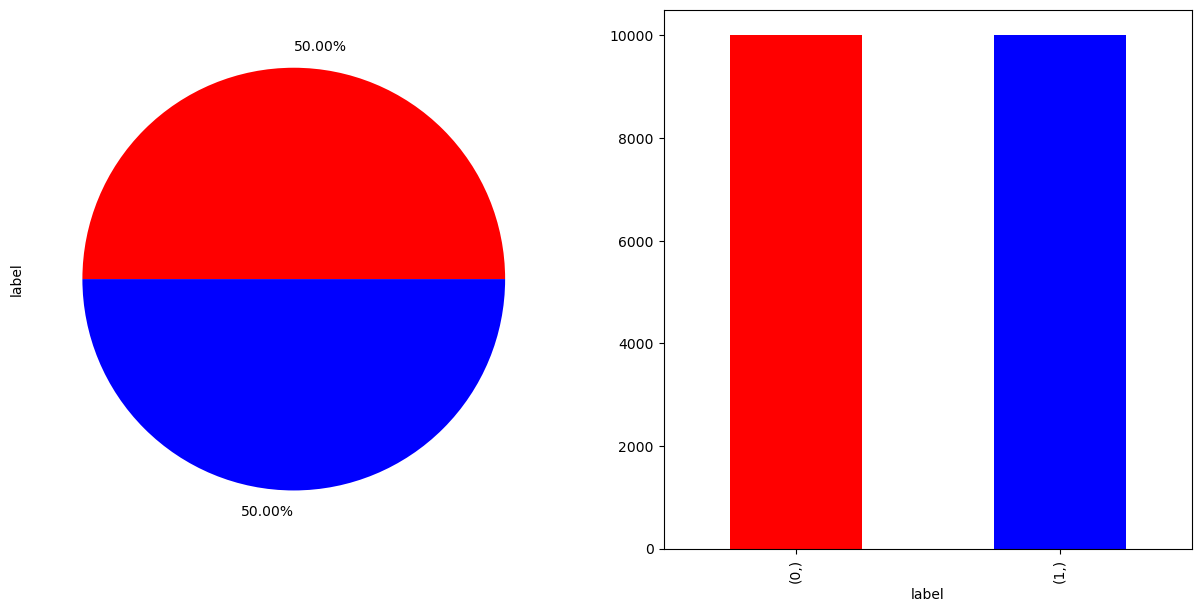

In [6]:
f, ax = plt.subplots(1, 2, figsize = (15, 7))
labels_names = [f"{p:.2f}%" for p in labels.value_counts()/labels.value_counts().sum()*100]
labels.value_counts().plot(kind='pie', ax=ax[0], labels=labels_names, colors=("r", "b"), ylabel="label")
labels.value_counts().plot(kind='bar', ax=ax[1], color=("r", "b"))

# Submissions files
Each file name in the submissions folder corresponds to the logloss score of the the first half of the prediction rows (20k rows) against the ground truth labels in that file. This is effectively the "training" set.

In [7]:
s0 = pd.read_csv(path / 'submission_files' / subs[0], index_col='id')

score = log_loss(labels, s0.loc[gt_ids])

# Notice the score of the labeled rows matches the file name
print(subs[0],' log_loss:', f'{score:.10f}')

0.6222863195.csv  log_loss: 0.6224367273


In [8]:
subs[0:10]

['0.6222863195.csv',
 '0.6223807245.csv',
 '0.6225426578.csv',
 '0.6247722291.csv',
 '0.6253455681.csv',
 '0.6254850917.csv',
 '0.6255093621.csv',
 '0.6260141578.csv',
 '0.6263493693.csv',
 '0.6272779211.csv']

# Loading all submission files
we are going to load all submission files into a dataframe with final shape 40k x 5k. Each Submission file will go into a column of the dataframe

We also calculate the ROC-AUC for each submission file in order to use this metric later

In [9]:
X_train_orig = np.zeros((s0.shape[0], len(subs)))
roc_auc_scores = {}


for i, name in  tqdm(enumerate(subs)):
    sub = pd.read_csv(path / 'submission_files' / name, index_col='id')
    X_train_orig[:,i] = sub.pred.values
    auc_score=roc_auc_score(labels.label[0:20000], X_train_orig[0:20000,i])
    roc_auc_scores[name]=auc_score
X_train_orig = pd.DataFrame(X_train_orig, columns=subs)

5000it [02:24, 34.60it/s]


In [10]:
X_train_orig.head(10)

,0.6222863195.csv,0.6223807245.csv,0.6225426578.csv,0.6247722291.csv,0.6253455681.csv,0.6254850917.csv,0.6255093621.csv,0.6260141578.csv,0.6263493693.csv,0.6272779211.csv,...,0.7519100517.csv,0.7519556278.csv,0.7520219713.csv,0.7521219579.csv,0.7522329272.csv,0.7523602310.csv,0.7526089604.csv,0.7526999358.csv,0.7551167673.csv,0.7575039918.csv
0,0.709336,0.799007,0.851891,0.537158,0.623930,0.705970,0.503437,0.633185,0.641550,0.666604,...,0.769207,0.750250,0.663370,0.739333,0.822384,0.749498,0.729800,0.867847,0.745888,0.787
1,0.452988,0.364453,0.567582,0.354468,0.513818,0.584119,0.454809,0.238501,0.472171,0.522314,...,0.640052,0.794052,0.721298,0.804369,0.620626,0.733606,0.816942,0.814229,0.598331,0.547
2,0.675462,0.842260,0.800013,0.525229,0.692071,0.715418,0.651008,0.609124,0.691198,0.609994,...,0.812841,0.779859,0.865657,0.828493,0.763010,0.802883,0.806891,0.896058,0.855776,0.667
3,0.481046,0.577118,0.683032,0.541356,0.630088,0.664514,0.413373,0.508210,0.526140,0.584565,...,0.824703,0.799698,0.800130,0.716604,0.603779,0.708499,0.844837,0.853057,0.850657,0.622
4,0.957339,0.910337,0.917322,0.874487,0.787595,0.854273,0.843846,0.876749,0.821128,0.913054,...,0.934803,0.900150,0.960911,0.906037,0.961240,0.935608,0.889757,0.978505,0.953681,0.934
5,0.831414,0.598125,0.276116,0.525463,0.734328,0.520369,0.081827,0.532379,0.821128,0.904294,...,0.908995,0.823174,0.912174,0.930805,0.571190,0.926527,0.889757,0.939157,0.908295,0.935
6,0.716171,0.424948,0.692054,0.328312,0.622229,0.687056,0.502608,0.501735,0.611488,0.580623,...,0.779942,0.716931,0.689678,0.661001,0.856190,0.709248,0.626589,0.575874,0.726107,0.434
7,0.953687,0.934748,0.942298,0.858528,0.794114,0.846232,0.841102,0.951427,0.775044,0.941849,...,0.933843,0.912999,0.930557,0.946958,0.985094,0.970721,0.872210,0.971870,0.933964,0.837
8,0.427233,0.372343,0.814237,0.555591,0.533184,0.609211,0.552825,0.402674,0.509153,0.569622,...,0.587888,0.681688,0.661960,0.608619,0.667168,0.617447,0.659957,0.808672,0.628330,1.000
9,0.619906,0.719119,0.685702,0.640120,0.659804,0.705191,0.497439,0.563905,0.543911,0.529731,...,0.808328,0.776024,0.778681,0.821828,0.814284,0.808427,0.753920,0.816997,0.671402,0.658


# Removing Strange submission files
we are going to remove strange submission files with values >1 or <0
As result we remove 108 submission files

- Instead of removing strange submission files we try to clip all
- we try to test some results coming from my AutoML notebook https://www.kaggle.com/code/infrarosso/automl-autoviz-pycaret
 

In [11]:
# instead of remove features with strange values I'll try to clip
X_train_orig = X_train_orig.loc[:, X_train_orig.max()<=1]
X_train_orig = X_train_orig.loc[:, X_train_orig.min()>=0]
# X_train_orig = X_train_orig.clip(0,1)

# testing some results coming from my AutoML notebook
# ref. https://www.kaggle.com/code/infrarosso/automl-autoviz-pycaret
# 2 variables removed since they were low-information variables
# DROP_LOW_INFO_FEATURES =  ['0.6933054832.csv', '0.6933472206.csv']
# X_train_orig = X_train_orig[list(set(X_train_orig.columns)-set(DROP_LOW_INFO_FEATURES))]

# Calibration of Train set
Our train set is composed of several models' predictions output, so it's a good idea to calibrate their output before training a blended model with these

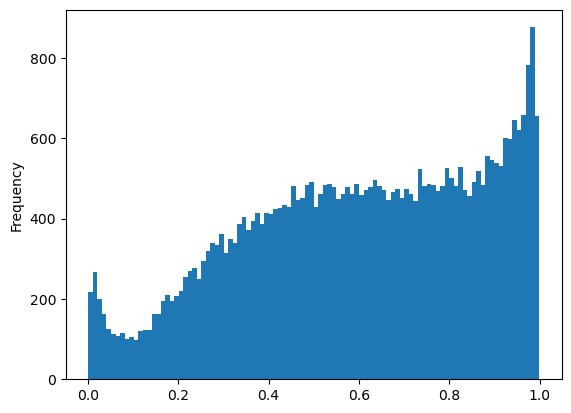

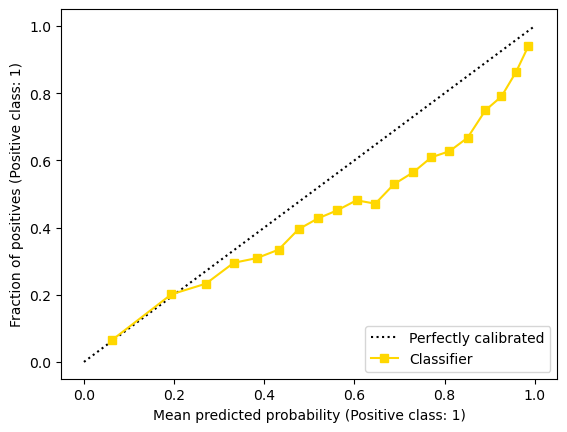

In [12]:
# example of an uncalibrated model prediction on train set
X_train_orig[:20000]['0.6222863195.csv']
X_train_orig[:]['0.6223807245.csv'].plot(kind='hist', bins=100)
CalibrationDisplay.from_predictions(labels.label[0:20000], X_train_orig[0:20000]['0.6223807245.csv'], n_bins=20,
                                        strategy='quantile', color='#ffd700')

4892it [24:02,  3.39it/s]


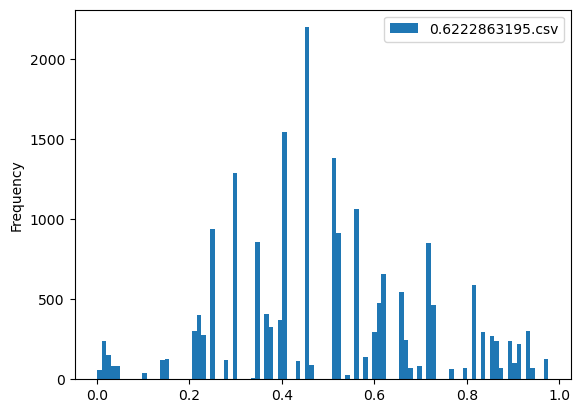

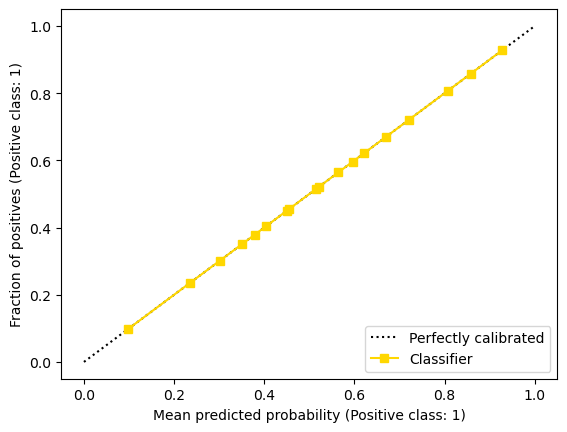

In [13]:
# train set calibration 
# ref. https://www.kaggle.com/competitions/tabular-playground-series-nov-2022/discussion/363778
roc_auc_scores_calibrated = {}
X_train_calibrated = X_train_orig.copy()
for i, c in tqdm(enumerate(X_train_orig.columns)):
    x_model_calibration = np.zeros(40000)
    model_calibration = IsotonicRegression(out_of_bounds='clip')
    x_model_calibration[:20000] = model_calibration.fit_transform(X_train_orig[:20000][c], labels.label).clip(0.001, 0.999)
    x_model_calibration[20000:] = model_calibration.transform(X_train_orig[20000:][c]).clip(0.001, 0.999)
    X_train_calibrated[c] = x_model_calibration
    auc_score=roc_auc_score(labels.label[0:20000], x_model_calibration[0:20000])
    roc_auc_scores_calibrated[c]=auc_score
pd.DataFrame(X_train_calibrated[:20000][X_train_calibrated.columns[0]]).plot(kind='hist', bins=100)
CalibrationDisplay.from_predictions(labels.label[0:20000], X_train_calibrated[:20000][X_train_calibrated.columns[0]], n_bins=20,
                                        strategy='quantile', color='#ffd700')

# Dimensionality Reduction with ROC-AUC? Why not!

<img src="https://i.imgflip.com/6z74zp.jpg"/>

## Idea for Feature Selection using ROC-AUC
A bad classifier can be identified by the ROC curve which looks very similar, if not identical, to the diagonal of the graph, representing the performance of a purely random classifier; ROC-AUC scores close to 0.5 are considered near-random results.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Roc_curve.svg/1024px-Roc_curve.svg.png" width="500px"/>

Starting from the concepts behind ROC-AUC explained above, we are going to use only submissions where the ROC-AUC is major of a threshold



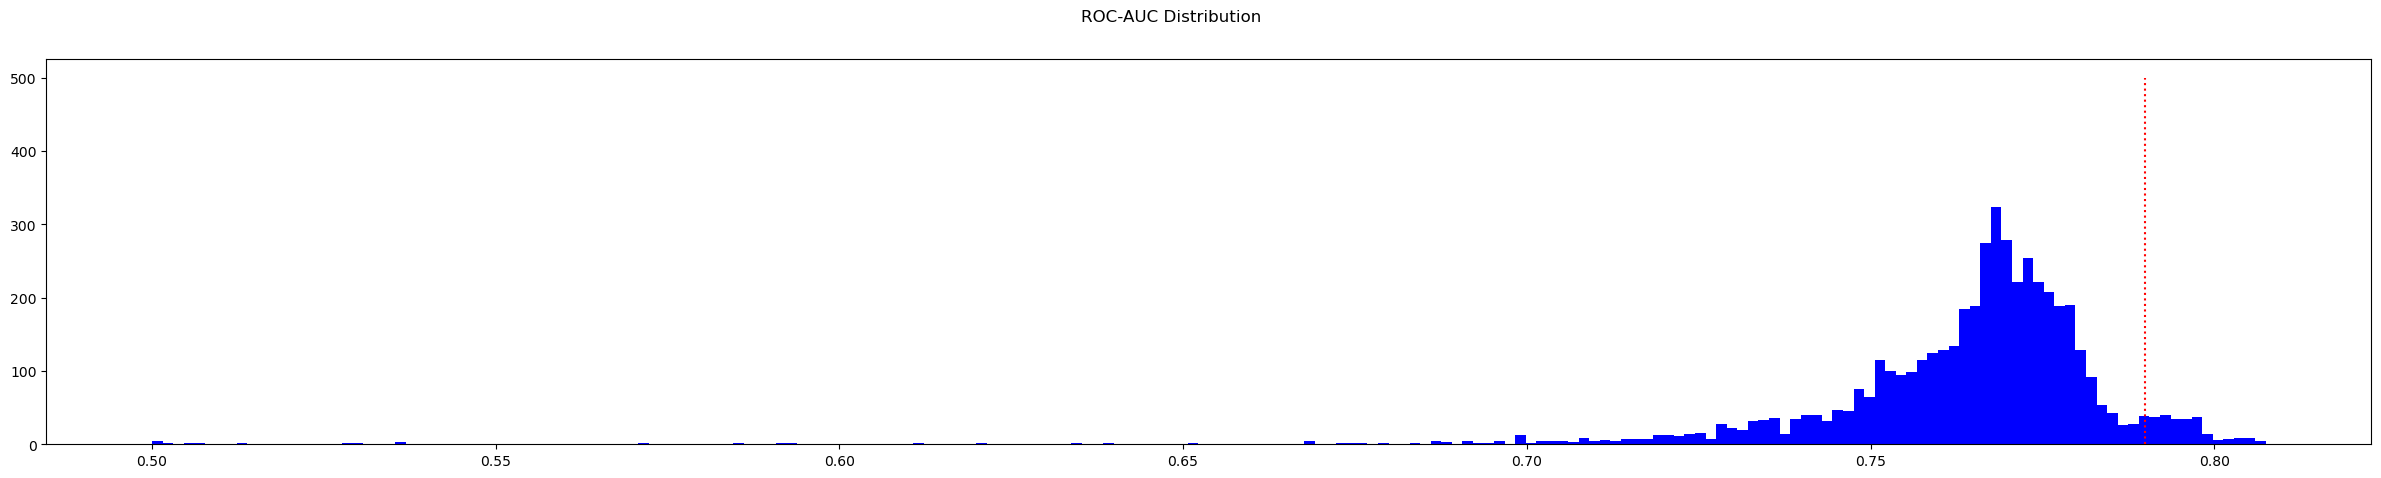

In [14]:
#AUC_TH = 0.797
AUC_TH = 0.79
fig = plt.figure(figsize=(30,5))
fig.suptitle("ROC-AUC Distribution")
out = plt.hist(roc_auc_scores_calibrated.values(), bins=200, color=("b"))
plt.plot([AUC_TH,AUC_TH],[0,500], linestyle='dotted', c="r")

In [15]:
SELECTED_FEATURES = []
TOP_LOG_LOSS_TH = 500
for k, v in roc_auc_scores_calibrated.items():
    if v>=AUC_TH:
        if k in X_train_orig.columns:
            SELECTED_FEATURES.append(k)
print(len(SELECTED_FEATURES), SELECTED_FEATURES[:TOP_LOG_LOSS_TH])
X_train_reduced = X_train_calibrated[SELECTED_FEATURES[:TOP_LOG_LOSS_TH]]
print(X_train_reduced.shape)

248 ['0.6225426578.csv', '0.6404491258.csv', '0.6426110725.csv', '0.6453694232.csv', '0.6454086279.csv', '0.6454375051.csv', '0.6460118158.csv', '0.6464892546.csv', '0.6475577136.csv', '0.6483090984.csv', '0.6485743466.csv', '0.6492627054.csv', '0.6493925862.csv', '0.6495194746.csv', '0.6495843938.csv', '0.6498444213.csv', '0.6498855044.csv', '0.6499879028.csv', '0.6500630905.csv', '0.6500863890.csv', '0.6501070159.csv', '0.6501134385.csv', '0.6503186151.csv', '0.6507043652.csv', '0.6510016540.csv', '0.6513124137.csv', '0.6515649417.csv', '0.6517195011.csv', '0.6518079470.csv', '0.6522976597.csv', '0.6523331629.csv', '0.6524028654.csv', '0.6532083105.csv', '0.6536305235.csv', '0.6538530574.csv', '0.6539581547.csv', '0.6541278746.csv', '0.6544952482.csv', '0.6552358052.csv', '0.6557547476.csv', '0.6560480516.csv', '0.6563223387.csv', '0.6563293718.csv', '0.6564147356.csv', '0.6564517315.csv', '0.6565234650.csv', '0.6567644357.csv', '0.6568310284.csv', '0.6569363374.csv', '0.6570332931.c

# Feature Selection with MRMR (optional)
Maximum Relevance — Minimum Redundancy” (aka MRMR) is an algorithm used by Uber’s machine learning platform for finding the “minimal-optimal” subset of features.

- Enabling FEATURE_SELECTION_ENABLED the train will be done with the features selection algorithm
- Disabling FEATURE_SELECTION_ENABLED the train will be done with all features availables in the train set (all columns)

In [16]:
FEATURE_SELECTION_ENABLED = True
# FEATURE SELECTION MRMR
def feature_selection(X, y, k):
    if not FEATURE_SELECTION_ENABLED:
        return X.columns
    out = mrmr_classif(X, y, k)
    print("Features selection:", out)
    return out

if FEATURE_SELECTION_ENABLED:
    FEATURES_SELECTED = feature_selection(X_train_reduced[0:20000], labels.label, 50)
    X_train_reduced = X_train_reduced[FEATURES_SELECTED]

100%|██████████| 50/50 [00:12<00:00,  3.91it/s]

Features selection: ['0.6492627054.csv', '0.6454375051.csv', '0.6501134385.csv', '0.6498855044.csv', '0.6564517315.csv', '0.6475577136.csv', '0.6495843938.csv', '0.6453694232.csv', '0.6513124137.csv', '0.6493925862.csv', '0.6589328974.csv', '0.6483090984.csv', '0.6510016540.csv', '0.6495194746.csv', '0.6522976597.csv', '0.6515649417.csv', '0.6500630905.csv', '0.6603536662.csv', '0.6485743466.csv', '0.6524028654.csv', '0.6557547476.csv', '0.6532083105.csv', '0.6570599977.csv', '0.6541278746.csv', '0.6563223387.csv', '0.6518079470.csv', '0.6498444213.csv', '0.6500863890.csv', '0.6582025555.csv', '0.6426110725.csv', '0.6517195011.csv', '0.6620201058.csv', '0.6503186151.csv', '0.6707095794.csv', '0.6593521643.csv', '0.6589751776.csv', '0.6601920939.csv', '0.6597075436.csv', '0.6523331629.csv', '0.6778730537.csv', '0.6924123007.csv', '0.6560480516.csv', '0.6587034723.csv', '0.6593057142.csv', '0.6501070159.csv', '0.6564147356.csv', '0.6702783631.csv', '0.6599082809.csv', '0.6603097589.csv',

# Feature Engineering
## Adding Unsupervised new feature

we try to add an unsupervised new feature calculated with kmeans and others as combination of features and mean

In [17]:
from sklearn.cluster import KMeans

#
X_train_reduced['cluster'] = KMeans(n_clusters=2, random_state=seed).fit_predict(X_train_reduced)
X_train_reduced['mean'] = X_train_reduced.mean(axis=1)
# compose a new feature as combination of two best features
X_train_reduced['compose_feature'] = (X_train_reduced['0.6778730537.csv'] + X_train_reduced['0.6702783631.csv'])/X_train_reduced['mean']

# Adversarial Validation

## Warning! I'm going to give you a spoiler of some results! 🖖
Here you can find a brief introduction and I'll give you a spoiler about results of the *Adversarial Validation* applied to this competition. 

-----------------------------------------------------------------------------

<img src="https://i.postimg.cc/wjTT17yX/adversarial-validation-drawio.png" style="float:right" width=300/>
In a real-world project we have to generalize at all costs, instead a Kaggle competition is more focused on having a model that works on the given test set, especially the private one 😎

We often expect test data to have the same distribution as training data, but in reality, this is not always the case because if differ, you need to understand if there is any possibility to mitigate the different distributions between training and test data and build a model that works on that set of tests. If you focus on this idea, you will have a better chance to discovering the best validation strategy, that will help you to rank higher in the competition.

The **adversarial validation** is a technique that allows you to estimate the degree of difference between training and test data

### And Here what we are going to do ?
The **Adversarial Validation** technique applied to the raw dataset of this competition (TPS Nov 2022) got a ROC-AUC of 0.50414901, so as it is close to 0.5, it means that the training and test data are not easily distinguishable and appear to come from the same distribution (great! 👌)

But in our notebooks before training our models, we start from the original dataset and we do some pre-processing stages before training, like feature selections, feature engineering and other pipeline elaborations.

The question running through my head is … **Will our processed train and test data, always be not easily distinguishable?**

In order to response of this question, here we are going to apply adversarial validation to the processed train/test dataset (X_train_reduced in my case).

So let's start!

In [18]:
# all dataset train + test
X_adversarial_validation = X_train_reduced
# 0 label for train dataset (first 20k rows) + 1 label for test dataset (last 20k rows) 
y_adversarial_validation = [0] * 20000 + [1] * 20000

# training all!
adversarial_model = RandomForestClassifier()
adversarial_cv_preds = cross_val_predict(adversarial_model, X_adversarial_validation, y_adversarial_validation, cv=5, n_jobs=-1, method='predict_proba')

# ROC-AUC as adversarial validation score
print(roc_auc_score(y_true=y_adversarial_validation, y_score=adversarial_cv_preds[:, 1]))

0.503544405


# Result 0.50358424 🚀
ROC-AUC on raw dataset and on processed dataset are around 0.5, it means that the processed training and test data that we are going to use to modelling are safe because are not easily distinguishable and appear to come from the same distribution.

<img src="https://i.imgflip.com/7188ac.jpg" width=200/>

# Blending/Stacking Model


In [19]:
FOLDS = 15
k_fold = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)
y = labels
X = X_train_reduced[0:20000]
X_test = X_train_reduced[20000:]


# RandomSearchCV
To find the best hyperparameters, we will use the RandomSearchCV. Random search is a technique more faster than GridSearchCV which calculates all possible combinations

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.01, shuffle=True, random_state= seed, stratify=y)
X_train = X_train.reset_index().drop("index", axis=1)
X_validation = X_validation.reset_index().drop("index", axis=1)
y_train = y_train.reset_index()['label']
y_validation = y_validation.reset_index()['label']

In [21]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform


lgbm_fit_params = {
    "eval_metric" : 'binary_logloss', 
    "eval_set" : [(X_validation, y_validation)],   
    'verbose':0
}

lgbm_param_test = {
    'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
    'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
    'num_leaves': sp_randint(6, 50, 100), 
    'min_child_samples': sp_randint(100, 500), 
    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'subsample': sp_uniform(loc=0.2, scale=0.8), 
    'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
    'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
}

cat_fit_params = {    
}

cat_param_test = {
    'depth'         : sp_randint(1, 10),
    'learning_rate' : sp_uniform(),
    'iterations'    : sp_randint(10, 300)
}

In [22]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

lgbm_rs = LGBMClassifier(metric= 'binary_logloss', 
                         random_state=seed, 
                         silent=True, 
                         n_jobs=-1
                        )

cat_rs = CatBoostClassifier(random_seed=seed, 
                                   eval_metric='Logloss',
                                   logging_level='Silent'
                                   )

random_search = RandomizedSearchCV(
    estimator=cat_rs, 
    param_distributions=cat_param_test,     
    scoring='neg_log_loss',
    cv=k_fold,
    refit=True,
    random_state=seed,
    verbose=100, n_iter=50
)

lgbm_opt_parameters = {
    'colsample_bytree': 0.45066268483824545,
    'learning_rate': 0.02,
    'max_depth': 5,
    'min_child_samples': 285,
    'min_child_weight': 0.01,
    'n_estimators': 300,
    'num_leaves': 116,
    'reg_alpha': 1,
    'reg_lambda': 1,
    'subsample': 0.532329735064063
}

cat_opt_parameters = {
   'depth': 3, 'iterations': 102, 'learning_rate': 0.15043761084876184
}


RS_FIT = False # enable it to use RandomSearchCV
if RS_FIT:
    random_search.fit(X, y, **cat_fit_params)
    opt_parameters =  random_search.best_params_
    print(opt_parameters)


# Hybrid Model Class
The following class permit us to encapsulate the logic of ensembling N models making a weighted average of their predictions (Soft-Voting)

We are going to choose several models in order to ensemble them and try to get better results

## Hybrid Model Schema

<img src="https://i.postimg.cc/prVWrkCg/hybrid-model-drawio.png"/>

In [23]:
class EnsembleHybrid:
   def __init__(self, models=[], weights=[]):
       self.models = models
       self.weights = weights

   def fit(self, X, y):
       # Train models
       for m in self.models:
           print(f"Training {m}...")
           m.fit(X, y)

   def predict_proba(self, X_test):
       y_pred = pd.Series(np.zeros(X_test.shape[0]), index=X_test.index)
       for i, m in enumerate(self.models):
           y_pred += pd.Series(m.predict_proba(X_test)[:,1], index=X_test.index) * self.weights[i]
       return y_pred

In [24]:
def folds_model(debug=True):
    # several models in order to stacking
    lgbm = LGBMClassifier(**lgbm_opt_parameters, objective='binary', silent=True,
                              random_state=seed,
                              metric='binary_logloss')
    
    cat_boost = CatBoostClassifier(**cat_opt_parameters, random_seed=seed,
                                   eval_metric='Logloss',
                                   logging_level='Silent')


    xgbm = XGBClassifier(objective='binary:logistic',
                     random_state=seed,
                     learning_rate=0.1,
                     n_estimators=100,
                     max_depth=8, 
                     #tree_method='gpu_hist'
                    )
    
    models = [lgbm, cat_boost]
    weights=[0.2, 0.8]
    Y_validations, ensemble_val_preds, ensemble_test_preds, scores=[],[],[],[]
    for fold, (train_idx, val_idx) in enumerate(k_fold.split(X, y)):
        if debug:
            print("\nFold {}".format(fold+1))
        X_fold_val, Y_fold_val = X.iloc[val_idx,:], y.label[val_idx]
        X_fold_train, Y_fold_train = X.iloc[train_idx,:], y.label[train_idx]
        if debug:
            print("Train shape: {}, {}, Valid shape: {}, {}".format(
            X_fold_train.shape, Y_fold_train.shape, X_fold_val.shape, Y_fold_val.shape))

        ensemble_model = EnsembleHybrid(models=models, weights=weights)
        ensemble_model.fit(X_fold_train, Y_fold_train)
        model_prob = ensemble_model.predict_proba(X_fold_val)        

        ensemble_prob = ensemble_model.predict_proba(X_fold_val)
        Y_validations.append(Y_fold_val)
        ensemble_val_preds.append(ensemble_prob)
        ensemble_test_preds.append(ensemble_model.predict_proba(X_test))        

        score=log_loss(Y_fold_val, ensemble_prob)
        scores.append(score)
        if debug:
            print(f"Fold {fold+1} Validation Score = {score:.4f}")

        del X_fold_train, Y_fold_train, X_fold_val, Y_fold_val 
    mix_score = sum(scores)/FOLDS
    if debug:
        print("Total Score (Mixing Folds Predictions) = {:.4f}".format(mix_score))
    return mix_score, ensemble_test_preds

score, ensemble_test_preds = folds_model()


Fold 1
Train shape: (18666, 53), (18666,), Valid shape: (1334, 53), (1334,)
Training LGBMClassifier(colsample_bytree=0.45066268483824545, learning_rate=0.02,
               max_depth=5, metric='binary_logloss', min_child_samples=285,
               min_child_weight=0.01, n_estimators=300, num_leaves=116,
               objective='binary', random_state=42, reg_alpha=1, reg_lambda=1,
               silent=True, subsample=0.532329735064063)...
Training <catboost.core.CatBoostClassifier object at 0x78527bedb250>...
Fold 1 Validation Score = 0.5438

Fold 2
Train shape: (18666, 53), (18666,), Valid shape: (1334, 53), (1334,)
Training LGBMClassifier(colsample_bytree=0.45066268483824545, learning_rate=0.02,
               max_depth=5, metric='binary_logloss', min_child_samples=285,
               min_child_weight=0.01, n_estimators=300, num_leaves=116,
               objective='binary', random_state=42, reg_alpha=1, reg_lambda=1,
               silent=True, subsample=0.532329735064063)...
Tra

# Final Submission

In [25]:
folds_blend = np.zeros(X_test.shape[0])
for j in range(FOLDS):
    folds_blend += ensemble_test_preds[j]
folds_blend = folds_blend/FOLDS

# testing final clip in order to improve logloss
th = 0.01
folds_blend_clipped = np.clip(folds_blend, th, 1-th)
submission['pred'] = folds_blend_clipped
submission.to_csv("final_submission_folds_mix.csv")